# Основная модель

In [43]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from scipy.spatial.distance import cosine
from numpy.linalg import norm

In [2]:
def save(obj, filename):
    with open(filename + ".pkl", "wb") as out:
        pickle.dump(obj, out, 2)
def load(filename):
    with open(filename + ".pkl", "rb") as inp:
        return pickle.load(inp)

In [17]:
train_df = pd.read_csv("data/train.csv")
train_df

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
...,...,...
3159628,そんな所で捕まっている片手は 70億の人々と繫がる命綱なのです,ja
3159629,Първоначално се опитах да направя думите &quot...,bg
3159630,Ho appreso che ha a che fare con l&apos; atten...,it
3159631,E os edifícios não se limitam a apenas evocar ...,pt-br


Будем искать ошибки в разметке. Посмотрим, встречаются ли какие-то тексты несколько раз. Для этого отсортируем тексты по частоте

In [18]:
sent_count = (
    train_df.sentence.value_counts()
    .to_frame()
    .reset_index()
)
sent_count.head(10)

,index,sentence
0,що це тому ми чи дуже які щоб дякую якщо було ...,75000
1,бұл мен біз бір үшін ол деп және емес бар кере...,50000
2,гэта што калі мы не яны як але ён каб дзякуй б...,50000
3,the and of it that you to apos we this is in t...,50000
4,это что мы не как на вы они но из то он так дл...,50000
5,що це ми не як на вони та але ви до про він оп...,50000
6,笑声 掌声 谢谢 现在 所以 事实上 当然 鼓掌 但是 因此 那么 非常感谢 谢谢大家 是的 好吧,25000
7,笑聲 掌聲 謝謝 所以 現在 事實上 當然 因此 謝謝大家 對吧 但是 鼓掌 謝謝各位 他說 我說,25000
8,( Aplausos ),1279
9,( Applaus ),1067


Действительно, кто-то желает подпортить нам обучение. Избавимся от текстов котрые встречаются много раз, а именно от первых восьми в sent_count

In [19]:
mistakes = list(sent_count.iloc[:8]["index"])
for item in mistakes:
    train_df = train_df[(train_df["sentence"] != item)]
train_df.reset_index(drop=True, inplace=True)
train_df

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
...,...,...
2784628,そんな所で捕まっている片手は 70億の人々と繫がる命綱なのです,ja
2784629,Първоначално се опитах да направя думите &quot...,bg
2784630,Ho appreso che ha a che fare con l&apos; atten...,it
2784631,E os edifícios não se limitam a apenas evocar ...,pt-br


Отделяем целевую переменную от остального датасета и кодируем ее значения

In [6]:
target = train_df.language
train_df.drop(columns=['language'], inplace=True)
label_encoder = LabelEncoder().fit(target)
y = label_encoder.transform(target)

Составляем pipeline и обучаем нашу модель. В качество тоекнов будут выступать n-грамы, где n варьируется от 2 до 4. Не забываем добавить балансировку, так как классы не сбалансированные

In [7]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer="char_wb", ngram_range=(2, 4))),
    ('model', SGDClassifier(random_state=42, loss='modified_huber', class_weight='balanced'))
])

In [8]:
%%time
pipe.fit(train_df.sentence, y)

Wall time: 35min 54s


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char_wb', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(2, 4), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_p...
                 SGDClassifier(alpha=0.0001, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                   

Оценим точность классификации на обучающей выборке

In [10]:
%%time
predictions = pipe.predict(train_df.sentence)

Wall time: 15min 50s


In [11]:
balanced_accuracy_score(y, predictions)

0.9267296048572796

Построим confusion_matrix

Wall time: 6.77 s


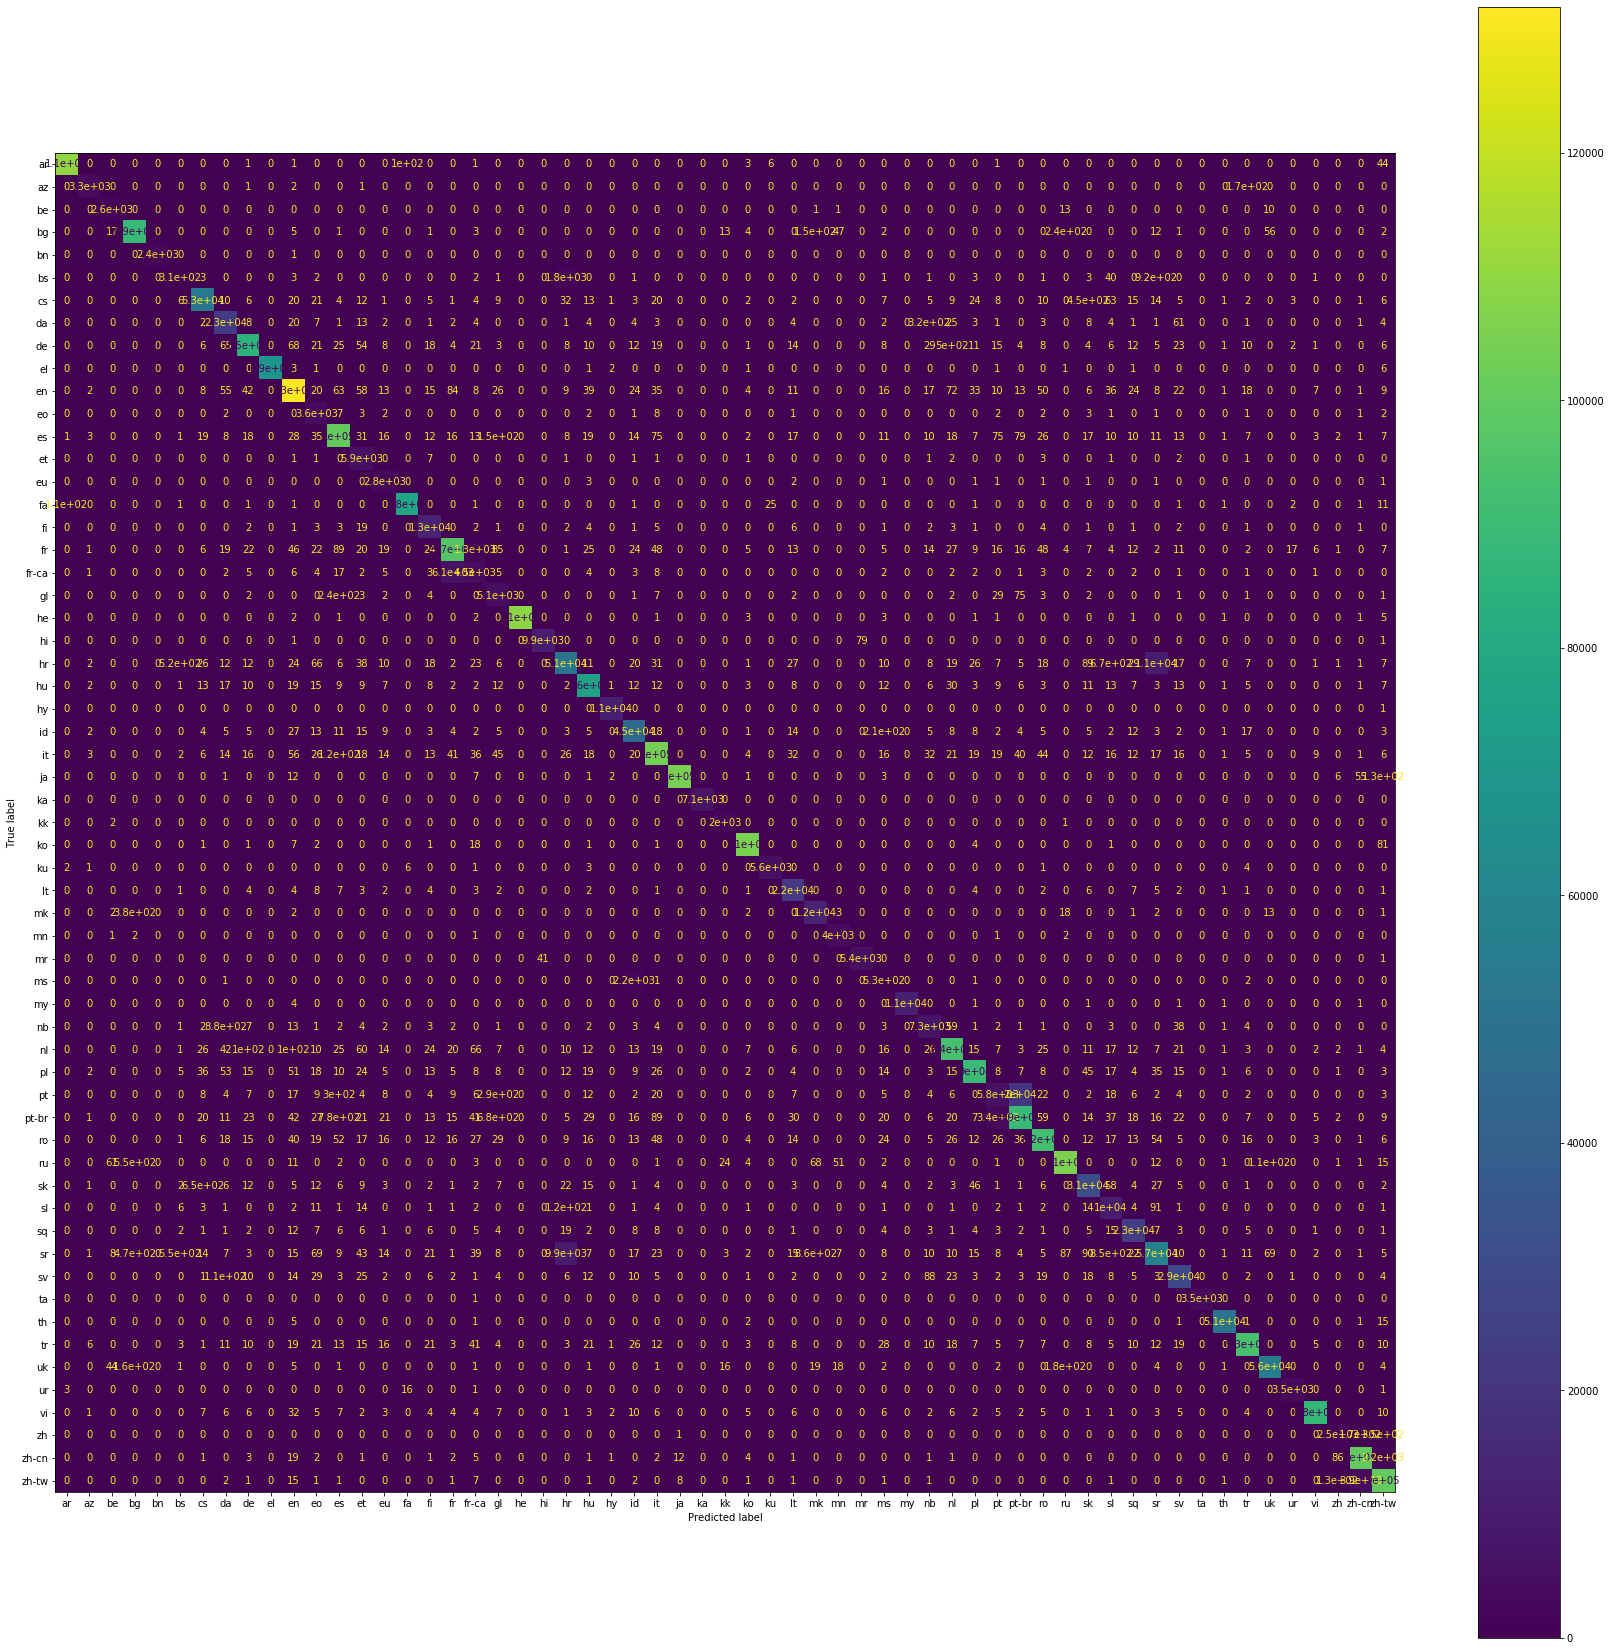

In [55]:
%%time
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(30, 30))
cm = confusion_matrix(y, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)    
# disp.figure_()
disp.plot(ax=ax)
# plot_confusion_matrix(estimator, train_df.sentence.values, y, display_labels=label_encoder.classes_)
# plt.show()

Выведем по пять самых важных токенов для каждого языка

In [46]:
pipe["model"].intercept_

array([-0.95584211, -0.96695631, -0.97586117, -0.98334256, -0.97552278,
       -0.98813719, -0.97033362, -0.99148188, -1.00560182, -0.96543691,
       -1.07892984, -1.05444411, -1.02479012, -0.98569871, -1.12535053,
       -0.98380429, -0.98171588, -0.9899366 , -0.99854917, -0.99305013,
       -0.96104347, -0.9714805 , -0.98285254, -0.97449915, -0.96684422,
       -1.00308744, -1.07720086, -0.7373545 , -0.96756928, -0.9700857 ,
       -0.87969277, -0.96881873, -0.97945036, -0.9801676 , -0.97323968,
       -0.96785045, -1.04193201, -0.98186711, -0.99553033, -1.02144475,
       -0.97465283, -0.97368324, -0.99331029, -0.99138645, -0.97211835,
       -0.97502686, -0.99696362, -0.99233426, -0.98603417, -0.98882246,
       -0.98855902, -0.95050869, -0.9824359 , -0.96986231, -1.23846437,
       -0.98186805, -0.73024587, -0.73865871, -0.70153552])

Прогоним тестовые данные

In [12]:
train_df = pd.read_csv("data/test.csv")

In [15]:
%%time
prediction = pipe.predict(train_df.sentence)
train_df['language'] = label_encoder.classes_[prediction]
train_df.head(10)

Wall time: 23min 50s


,index,sentence,language
0,0,תודה לכם .,he
1,1,"Precisamos de compaixão para começar , e auto-...",pt-br
2,2,這個增長相當大 ， 並且它將引發經濟的增長 。,zh-tw
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요 .,ko
4,4,これをロボットに組み込みました,ja
5,5,所以他們拿了紅綠藍 ， 不是只拿訂單上的部分貨物 。,zh-tw
6,6,"Van , aki felelősségteljesen .",hu
7,7,"Geen enkele , want Disney is niet van plan om ...",nl
8,8,"Я хотел вас оставить сегодня с идеей , что есл...",ru
9,9,"Najuzbudljivija je Harlem dječja zona , koja v...",hr


In [16]:
train_df[['index',  'language']].to_csv('data/SmirnovGS.csv', index=False)

# Замечание
Ниже приведен пример того, как можно добавить признаки на основе word2vec (в моих запусках это не дало прироста точности)

Для начала разбиваем данные на слова

In [ ]:
from nltk import RegexpTokenizer
from collections import defaultdict
dic = defaultdict(set)
def tokenize(dataset, tokenized):
    tokenizer = RegexpTokenizer(r'\w+')
    for i in range(len(dataset)):
        tokenized.append(tokenizer.tokenize(dataset.sentence[i].lower()))
tokenized = []
tokenize(train_df, tokenized)

Обучаем word2vec-модель на полученных токенах

In [ ]:
from gensim.models.word2vec import Word2Vec
size = 100
w2v_model = Word2Vec(tokenized, min_count = 1, workers = 8, size=size) 
w2v_model.train(tokenized, total_examples = w2v_model.corpus_count, epochs = 3) 

Воспользуемся полученной моделью. Каждое слово из текста с помощью моедели переведём в вектор и возьмем среднее арифметическое по всем таким векторам

In [ ]:
def convert(data):
    X = np.zeros((len(data), size))
    for i in np.arange(len(data)):
        print(i)
        line = [tok for tok in data[i] if tok in w2v_model.wv]
        length = len(line)
        for word in line:
            X[i] += w2v_model.wv[word]/length
    return X
matrix = convert(tokenized)

Добавить полученную матрицу к исходным признакам можно например следующим образом

In [ ]:
class w2vTransformerTrain():

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return matrix
    
union_pipe = FeatureUnion(transformer_list=[
          ('vectorizer', TfidfVectorizer(analyzer="char_wb", ngram_range=(2, 4))),
          ('w2v', w2vTransformerTrain())
          ])

pipe = Pipeline([
    ('feat_union', union_pipe),
    ('model', SGDClassifier(random_state=42, loss='modified_huber', class_weight='balanced', n_jobs=-1, verbose=1))
    ], verbose=True)

Помимо непосредственно векторов, полученных из word2vec модели, можно рассчитать центры для каждого языка и посчитать косинунсное расстояние вектора текста до каждого центра

Для начала расчитаем центры

In [ ]:
lang_count = (
    train_df.language.value_counts()
    .to_frame()
    .reset_index()
)

centres = defaultdict(np.array)

for lang in lang_count.keys():
    centres[lang] = np.zeros(size)
    
for i in range(len(matrix)):
    print(i)
    centres[target[i]] += matrix[i] / lang_count[target[i]]

Далее, расчитаем расстояния до каждого центра

In [ ]:
cosine_dist = np.zeros((len(matrix), len(lang_count)))
for i, vec in enumerate(matrix):
    for j, lang in centres.keys():
        cosine_dist[i][j] = cosine(centres[lang], vec)

Полученную матрицу можно так же добавить к обучающей выборке, получится некоторое подобие стеккинга, так как косинусное расстояния до центров каждого языка уже с некоторой точностью предсказывают к какому языку нужно отнести текст